# Machine Learning Interpretability in Lapse Prediction for Non-Life Insurance Premium

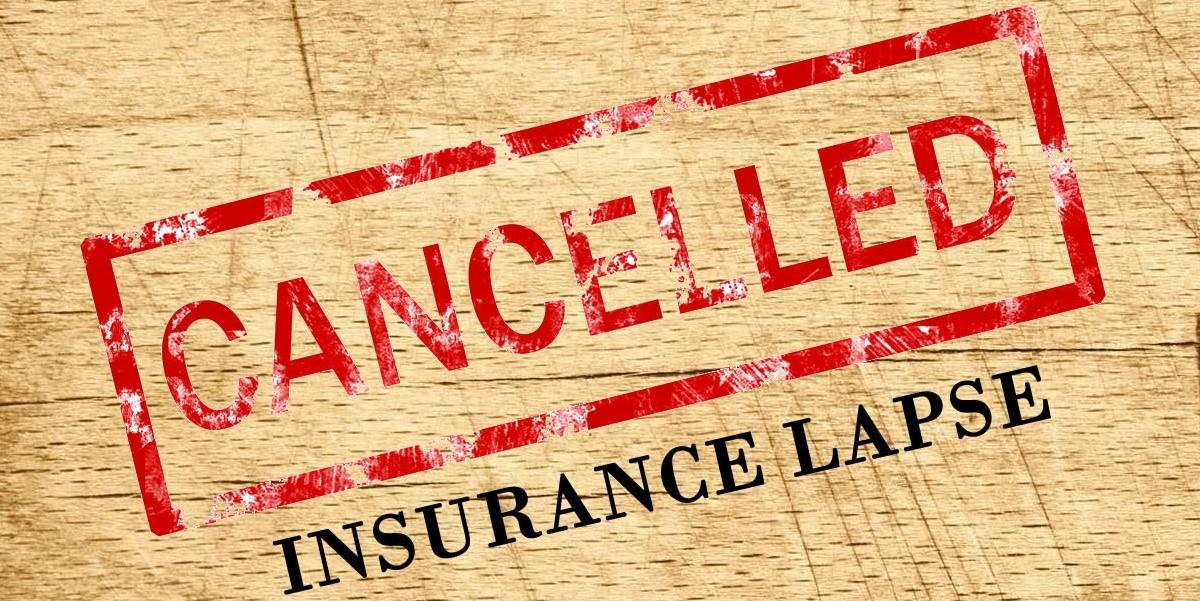

# Prepare Workspace

In [1]:
seed_value= 0
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [2]:
# to handle datasets
import random
import pandas as pd

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import scipy.stats as stats

# feature engineering
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc

# to split data set 
from sklearn.model_selection import train_test_split

# cross validation and tuning
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# feature scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# to handle imbalanced data set
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from collections import Counter

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


# explainability
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import PartialDependenceDisplay
import shap
import lime
import lime.lime_tabular


import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/eudirect-lapse/eudirectlapse.csv


In [4]:
df = pd.read_csv("/kaggle/input/eudirect-lapse/eudirectlapse.csv")

# Data set Overview

In [5]:
# Dimensions of data set
print(df.shape)

(23060, 19)


In [6]:
# List types for each attribute
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23060 entries, 0 to 23059
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lapse                 23060 non-null  int64  
 1   polholder_age         23060 non-null  int64  
 2   polholder_BMCevol     23060 non-null  object 
 3   polholder_diffdriver  23060 non-null  object 
 4   polholder_gender      23060 non-null  object 
 5   polholder_job         23060 non-null  object 
 6   policy_age            23060 non-null  int64  
 7   policy_caruse         23060 non-null  object 
 8   policy_nbcontract     23060 non-null  int64  
 9   prem_final            23060 non-null  float64
 10  prem_freqperyear      23060 non-null  object 
 11  prem_last             23060 non-null  float64
 12  prem_market           23060 non-null  float64
 13  prem_pure             23060 non-null  float64
 14  vehicl_age            23060 non-null  int64  
 15  vehicl_agepurchase 

In [7]:
# Take a peek at the first rows of the data
df.head()

lapse  polholder_age polholder_BMCevol polholder_diffdriver  \
0      0             38            stable         only partner   
1      1             35            stable                 same   
2      1             29            stable                 same   
3      0             33              down                 same   
4      0             50            stable                 same   

  polholder_gender polholder_job  policy_age              policy_caruse  \
0             Male        normal           1  private or freelance work   
1             Male        normal           1  private or freelance work   
2             Male        normal           0  private or freelance work   
3           Female       medical           2  private or freelance work   
4             Male        normal           8                    unknown   

   policy_nbcontract  prem_final prem_freqperyear  prem_last  prem_market  \
0                  1      232.46       4 per year     232.47       221.56   
1                  1      208.53       4 per year     208.54       247.56   
2                  1      277.34       1 per year     277.35       293.32   
3                  1      239.51       4 per year     244.40       310.91   
4                  1      554.54       4 per year     554.55       365.46   

   prem_pure  vehicl_age  vehicl_agepurchase       vehicl_garage  \
0     243.59           9                   8      private garage   
1     208.54          15                   7      private garage   
2     277.35          14                   6  underground garage   
3     219.95          17                  10              street   
4     519.50          16                   8              street   

  vehicl_powerkw vehicl_region  
0         225 kW          Reg7  
1         100 kW          Reg4  
2         100 kW          Reg7  
3          75 kW          Reg5  
4          75 kW         Reg14

# Data Cleaning 

### Delete single column values

In [8]:
# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
print(to_del)
# drop useless columns
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

[]
(23060, 19)


### Delete duplicate rows

In [9]:
# drop duplicate rows
df.drop_duplicates(inplace=True)
print(df.shape)

(23060, 19)


### Handling Missing Values

In [10]:
# Check missing values both to numeric features and categorical features 
missing = df.isnull().sum()/df.shape[0]*100
missing

lapse                   0.0
polholder_age           0.0
polholder_BMCevol       0.0
polholder_diffdriver    0.0
polholder_gender        0.0
polholder_job           0.0
policy_age              0.0
policy_caruse           0.0
policy_nbcontract       0.0
prem_final              0.0
prem_freqperyear        0.0
prem_last               0.0
prem_market             0.0
prem_pure               0.0
vehicl_age              0.0
vehicl_agepurchase      0.0
vehicl_garage           0.0
vehicl_powerkw          0.0
vehicl_region           0.0
dtype: float64

In [11]:
# Numerical format transformation of feature prem_freqperyear
df_1 = df.copy()
df_1['prem_freqperyear'] = df_1['prem_freqperyear'].str.extract('(\d+)') # extract numerical part
df_1['prem_freqperyear'] = df_1['prem_freqperyear'].astype('float') # format variale as numerical

# Pre-Processing

In [12]:
# Split data set between target variable and features
X_full = df_1.copy()
y = X_full.lapse
X_full.drop(['lapse'], axis=1, inplace=True)

In [13]:
# Merge categorical covariates with dependent variable
cat_y = pd.concat([y, X_full.polholder_BMCevol, X_full.polholder_diffdriver, X_full.polholder_gender, X_full.polholder_job,
                 X_full.policy_caruse, X_full.vehicl_garage, X_full.vehicl_powerkw, X_full.vehicl_region],axis=1)

In [14]:
# calculate the mean target value per category for each feature and capture the result in a dictionary 
polholder_BMCevol_LABELS = cat_y.groupby(['polholder_BMCevol'])['lapse'].mean().to_dict()
polholder_diffdriver_LABELS = cat_y.groupby(['polholder_diffdriver'])['lapse'].mean().to_dict()
polholder_gender_LABELS = cat_y.groupby(['polholder_gender'])['lapse'].mean().to_dict()
polholder_job_LABELS = cat_y.groupby(['polholder_job'])['lapse'].mean().to_dict()
policy_caruse_LABELS = cat_y.groupby(['policy_caruse'])['lapse'].mean().to_dict()
vehicl_garage_LABELS = cat_y.groupby(['vehicl_garage'])['lapse'].mean().to_dict()
vehicl_powerkw_LABELS = cat_y.groupby(['vehicl_powerkw'])['lapse'].mean().to_dict()
vehicl_region_LABELS = cat_y.groupby(['vehicl_region'])['lapse'].mean().to_dict()

In [15]:
# replace for each feature the labels with the mean target values
cat_y['polholder_BMCevol'] = cat_y['polholder_BMCevol'].map(polholder_BMCevol_LABELS)
cat_y['polholder_diffdriver'] = cat_y['polholder_diffdriver'].map(polholder_diffdriver_LABELS)
cat_y['polholder_gender'] = cat_y['polholder_gender'].map(polholder_gender_LABELS)
cat_y['polholder_job'] = cat_y['polholder_job'].map(polholder_job_LABELS)
cat_y['policy_caruse'] = cat_y['policy_caruse'].map(policy_caruse_LABELS)
cat_y['vehicl_garage'] = cat_y['vehicl_garage'].map(vehicl_garage_LABELS)
cat_y['vehicl_powerkw'] = cat_y['vehicl_powerkw'].map(vehicl_powerkw_LABELS)
cat_y['vehicl_region'] = cat_y['vehicl_region'].map(vehicl_region_LABELS)

In [16]:
# Look at the new subset
target_cat = cat_y.drop(['lapse'], axis=1)
target_cat.shape

(23060, 8)

In [17]:
target_cat.head()

polholder_BMCevol  polholder_diffdriver  polholder_gender  polholder_job  \
0           0.102277              0.128322          0.132939       0.133304   
1           0.102277              0.122546          0.132939       0.133304   
2           0.102277              0.122546          0.132939       0.133304   
3           0.161300              0.122546          0.119559       0.120650   
4           0.102277              0.122546          0.132939       0.133304   

   policy_caruse  vehicl_garage  vehicl_powerkw  vehicl_region  
0       0.135994       0.124901        0.103896       0.118504  
1       0.135994       0.124901        0.133307       0.126705  
2       0.135994       0.165720        0.133307       0.118504  
3       0.135994       0.123628        0.130574       0.100376  
4       0.083549       0.123628        0.130574       0.158262

In [18]:
encoded_data = pd.concat([X_full.polholder_age,X_full.policy_age,X_full.policy_nbcontract,X_full.prem_final,
                       X_full.prem_last, X_full.prem_market, X_full.prem_pure, X_full.vehicl_age, 
                       X_full.vehicl_agepurchase,X_full.prem_freqperyear, target_cat], axis=1)
encoded_data

polholder_age  policy_age  policy_nbcontract  prem_final  prem_last  \
0                 38           1                  1      232.46     232.47   
1                 35           1                  1      208.53     208.54   
2                 29           0                  1      277.34     277.35   
3                 33           2                  1      239.51     244.40   
4                 50           8                  1      554.54     554.55   
...              ...         ...                ...         ...        ...   
23055             32           3                  1      335.64     342.49   
23056             46           1                  1      254.15     254.16   
23057             35           1                  1      324.16     324.17   
23058             35           0                  1      190.13     190.14   
23059             39           1                  1      615.19     714.61   

       prem_market  prem_pure  vehicl_age  vehicl_agepurchase  \
0           221.56     243.59           9                   8   
1           247.56     208.54          15                   7   
2           293.32     277.35          14                   6   
3           310.91     219.95          17                  10   
4           365.46     519.50          16                   8   
...            ...        ...         ...                 ...   
23055       347.66     320.25           4                   1   
23056       235.79     263.91          11                   8   
23057       353.12     324.17          18                  14   
23058       227.93     174.94          14                  11   
23059       780.82     580.59          17                  11   

       prem_freqperyear  polholder_BMCevol  polholder_diffdriver  \
0                   4.0           0.102277              0.128322   
1                   4.0           0.102277              0.122546   
2                   1.0           0.102277              0.122546   
3                   4.0           0.161300              0.122546   
4                   4.0           0.102277              0.122546   
...                 ...                ...                   ...   
23055               2.0           0.161300              0.128322   
23056               1.0           0.102277              0.128322   
23057               4.0           0.102277              0.128322   
23058               2.0           0.102277              0.128322   
23059               2.0           0.161300              0.122546   

       polholder_gender  polholder_job  policy_caruse  vehicl_garage  \
0              0.132939       0.133304       0.135994       0.124901   
1              0.132939       0.133304       0.135994       0.124901   
2              0.132939       0.133304       0.135994       0.165720   
3              0.119559       0.120650       0.135994       0.123628   
4              0.132939       0.133304       0.083549       0.123628   
...                 ...            ...            ...            ...   
23055          0.132939       0.120650       0.135994       0.165720   
23056          0.119559       0.120650       0.135994       0.165720   
23057          0.119559       0.133304       0.135994       0.127508   
23058          0.132939       0.120650       0.135994       0.124901   
23059          0.132939       0.133304       0.135994       0.126616   

       vehicl_powerkw  vehicl_region  
0            0.103896       0.118504  
1            0.133307       0.126705  
2            0.133307       0.118504  
3            0.130574       0.100376  
4            0.130574       0.158262  
...               ...            ...  
23055        0.119186       0.126705  
23056        0.122786       0.149701  
23057        0.130574       0.126705  
23058        0.133307       0.131504  
23059        0.130574       0.131504  

[23060 rows x 18 columns]

In [19]:
# Standardization of data
encoded_data_sc = StandardScaler().fit_transform(encoded_data)
# PCA transformation of data set
pca = PCA(0.90, random_state=0)
pca_fe = pca.fit_transform(encoded_data_sc)
pca_df = pd.DataFrame(data = pca_fe, columns = ['pca'+str(i) for i in range(pca_fe.shape[1])])

### Numerical Features Pre-Processing

In [20]:
# Select numerical columns
numerical_cols = [cname for cname in X_full.columns if 
                X_full[cname].dtype in ['float64','int64']]

In [21]:
# Subset with numerical features
num = X_full[numerical_cols]
num.columns

Index(['polholder_age', 'policy_age', 'policy_nbcontract', 'prem_final',
       'prem_freqperyear', 'prem_last', 'prem_market', 'prem_pure',
       'vehicl_age', 'vehicl_agepurchase'],
      dtype='object')

In [22]:
# new subset for a bivariate analysis
num2 = pd.concat([y,num], axis=1)

In [23]:
# Anova Test
def select_features(X, y):
    # configure to select a subset of features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit_transform(X, y)
    return fs

# feature selection
fs = select_features(num, y)
pvalues = pd.DataFrame(fs.pvalues_, columns = ['pvalue'])
pvalues.index = num.columns
pvalues

pvalue
polholder_age       4.627428e-22
policy_age          5.425416e-21
policy_nbcontract   3.571800e-01
prem_final          4.924935e-09
prem_freqperyear    2.173495e-05
prem_last           1.323984e-09
prem_market         1.036711e-05
prem_pure           2.076163e-06
vehicl_age          3.479189e-14
vehicl_agepurchase  1.569897e-01

In [24]:
# drop not relevant features by feature selection
num_to_drop =['policy_nbcontract','vehicl_agepurchase']
num = num.drop(num[num_to_drop], axis=1)

In [25]:
num_o = num.copy()

In [26]:
# outliers correction
for col in num_o.columns:
    q75, q25 = np.percentile(num_o[col].dropna(), [75 ,25])
    iqr = q75 - q25 
    min = q25 - (iqr*1.5)
    max = q75 + (iqr*1.5) 
    num_o[col].loc[num_o[col] < min] = min
    num_o[col].loc[num_o[col] > max] = max

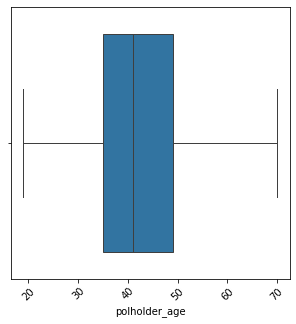

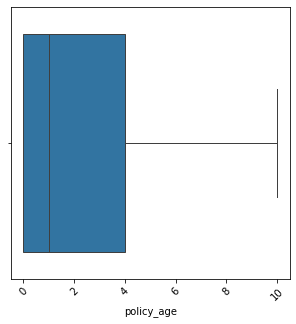

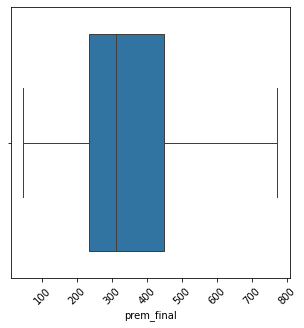

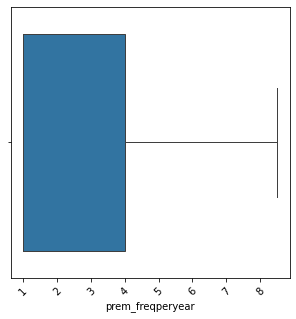

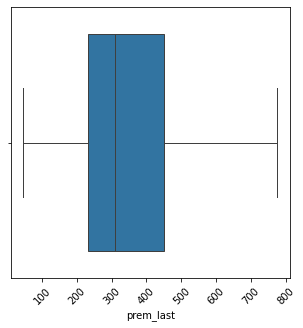

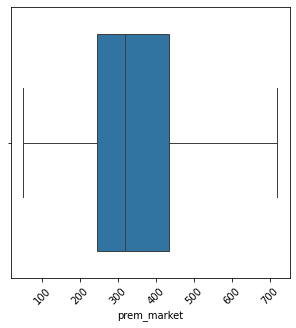

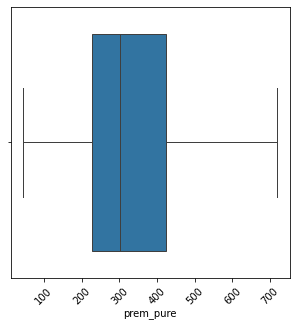

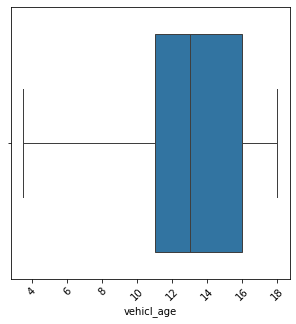

In [27]:
# check corrections
for col in num_o:
    plt.figure(figsize=(5,5))
    x=num_o[col]
    sns.boxplot(x,linewidth=1)
    plt.xticks(rotation=45)
    plt.show()

### Categorical Features Pre-Processing

In [28]:
# let's have a look at how many labels for categorical features
for col in X_full.columns:
    if X_full[col].dtype =="object":
        print(col, ': ', len(X_full[col].unique()), ' labels')

polholder_BMCevol :  3  labels
polholder_diffdriver :  7  labels
polholder_gender :  2  labels
polholder_job :  2  labels
policy_caruse :  3  labels
vehicl_garage :  8  labels
vehicl_powerkw :  11  labels
vehicl_region :  14  labels


In [29]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_full.columns if
                    X_full[cname].nunique() <= 15 and 
                    X_full[cname].dtype == "object"]

In [30]:
# Subset with categorical features
cat = X_full[categorical_cols]
cat.columns


Index(['polholder_BMCevol', 'polholder_diffdriver', 'polholder_gender',
       'polholder_job', 'policy_caruse', 'vehicl_garage', 'vehicl_powerkw',
       'vehicl_region'],
      dtype='object')

In [31]:
# new subset for a bivariate analysis
cat2 = pd.concat([y,cat], axis=1)

In [32]:
# Chi-Square Test
alpha = 0.05
selection = []
for var in cat:
    X = cat2[var].astype(str)
    Y = cat2['lapse'].astype(str)
    dfObserved = pd.crosstab(Y,X)
    p = stats.chi2_contingency(dfObserved.values)[1]
    selection.append(p)
    features = np.asarray(selection)

pvalues = pd.DataFrame(features, columns = ['pvalue'])
pvalues.index = cat.columns
pvalues

pvalue
polholder_BMCevol     1.214243e-39
polholder_diffdriver  4.076257e-06
polholder_gender      3.723144e-03
polholder_job         4.966704e-03
policy_caruse         1.225633e-16
vehicl_garage         3.085934e-03
vehicl_powerkw        7.086512e-01
vehicl_region         1.037137e-13

In [33]:
# drop no correlated features with target variable by Chi-Square test
to_drop=['vehicl_powerkw']
cat_ = cat.drop(cat[to_drop], axis=1)

### Re-grouping rare labels

In [34]:
cat_fe = cat_.copy()

In [35]:
def find_non_rare_labels(df, variable, tolerance):
    temp = df.groupby([variable])[variable].count() / len(df)
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]
    return non_rare

In [36]:
# non rare labels
find_non_rare_labels(cat_, 'polholder_BMCevol', 0.05)

['down', 'stable']

In [37]:
# rare labels
[x for x in cat_['polholder_BMCevol'].unique() if x not in find_non_rare_labels(cat_, 'polholder_BMCevol', 0.05)]

['up']

In [38]:
# most frequent label
frequent_cat = cat_.groupby('polholder_BMCevol')['polholder_BMCevol'].count().sort_values().tail(1).index.values[0]
frequent_cat

'stable'

In [39]:
# regroup labels
cat_fe['polholder_BMCevol'] = np.where(cat_fe['polholder_BMCevol'].isin(['up']), frequent_cat, cat_fe['polholder_BMCevol'])
# check
[x for x in cat_fe.polholder_BMCevol.unique() if x not in cat_fe.polholder_BMCevol.unique()]

[]

In [40]:
# non rare labels
find_non_rare_labels(cat_, 'polholder_diffdriver', 0.05)

['all drivers > 24', 'only partner', 'same', 'young drivers']

In [41]:
# rare labels
[x for x in cat_['polholder_diffdriver'].unique() if x not in find_non_rare_labels(cat_, 'polholder_diffdriver', 0.05)]

['learner 17', 'commercial', 'unknown']

In [42]:
# most frequent label
frequent_cat = cat_.groupby('polholder_diffdriver')['polholder_diffdriver'].count().sort_values().tail(1).index.values[0]
frequent_cat

'same'

In [43]:
# regroup labels
cat_fe['polholder_diffdriver'] = np.where(cat_fe['polholder_diffdriver'].isin(['learner 17', 'commercial', 'unknown']), frequent_cat, cat_fe['polholder_diffdriver'])
# check
[x for x in cat_fe.polholder_diffdriver.unique() if x not in cat_fe.polholder_diffdriver.unique()]

[]

In [44]:
# non rare labels
find_non_rare_labels(cat_, 'policy_caruse', 0.05)

['private or freelance work', 'unknown']

In [45]:
# rare labels
[x for x in cat_['policy_caruse'].unique() if x not in find_non_rare_labels(cat_, 'policy_caruse', 0.05)]

['commercial']

In [46]:
# most frequent label
frequent_cat = cat_.groupby('policy_caruse')['policy_caruse'].count().sort_values().tail(1).index.values[0]
frequent_cat

'private or freelance work'

In [47]:
# regroup labels
cat_fe['policy_caruse'] = np.where(cat_fe['policy_caruse'].isin(['commercial']), frequent_cat, cat_fe['policy_caruse'])
# check
[x for x in cat_fe.policy_caruse.unique() if x not in cat_fe.policy_caruse.unique()]

[]

In [48]:
# non rare labels
find_non_rare_labels(cat_, 'vehicl_garage', 0.05)

['carport', 'other', 'parking deck', 'private garage', 'street', 'unknown']

In [49]:
# rare labels
[x for x in cat_['vehicl_garage'].unique() if x not in find_non_rare_labels(cat_, 'vehicl_garage', 0.05)]

['underground garage', 'private estate']

In [50]:
# most frequent label
frequent_cat = cat_.groupby('vehicl_garage')['vehicl_garage'].count().sort_values().tail(1).index.values[0]
frequent_cat

'private garage'

In [51]:
# regroup labels
cat_fe['vehicl_garage'] = np.where(cat_fe['vehicl_garage'].isin(['underground garage']), frequent_cat, cat_fe['vehicl_garage'])
# check
[x for x in cat_fe.vehicl_garage.unique() if x not in cat_fe.vehicl_garage.unique()]

[]

In [52]:
second_cat = 'street'
# regroup labels
cat_fe['vehicl_garage'] = np.where(cat_fe['vehicl_garage'].isin(['private estate']), second_cat, cat_fe['vehicl_garage'])
# check
[x for x in cat_fe.vehicl_garage.unique() if x not in cat_fe.vehicl_garage.unique()]

[]

In [53]:
# non rare labels
find_non_rare_labels(cat_, 'vehicl_region', 0.05)

['Reg12', 'Reg14', 'Reg3', 'Reg4', 'Reg5', 'Reg7', 'Reg8', 'Reg9']

In [54]:
# rare labels
[x for x in cat_['vehicl_region'].unique() if x not in find_non_rare_labels(cat_, 'vehicl_region', 0.05)]

['Reg6', 'Reg10', 'Reg13', 'Reg11', 'Reg1', 'Reg2']

In [55]:
# most frequent label
frequent_cat = cat_.groupby('vehicl_region')['vehicl_region'].count().sort_values().tail(1).index.values[0]
frequent_cat

'Reg4'

In [56]:
# regroup labels in the first one
cat_fe['vehicl_region'] = np.where(cat_fe['vehicl_region'].isin(['Reg6', 'Reg10', 'Reg13']), frequent_cat, cat_fe['vehicl_region'])
# check
[x for x in cat_fe.vehicl_region.unique() if x not in cat_fe.vehicl_region.unique()]

[]

In [57]:
second_cat = 'Reg7'
# regroup labels
cat_fe['vehicl_region'] = np.where(cat_fe['vehicl_region'].isin(['Reg11', 'Reg1', 'Reg2']), second_cat, cat_fe['vehicl_region'])
# check
[x for x in cat_fe.vehicl_region.unique() if x not in cat_fe.vehicl_region.unique()]

[]

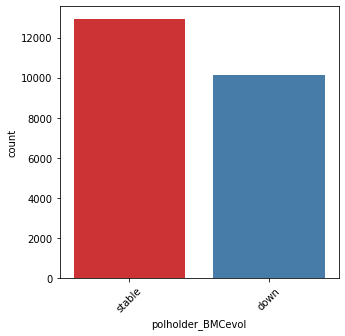

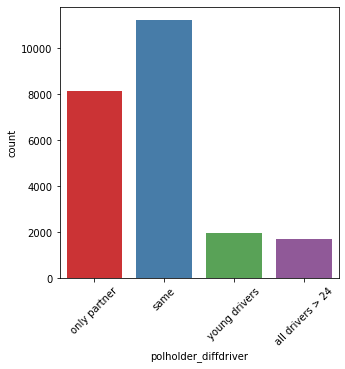

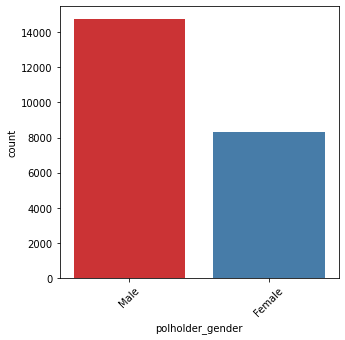

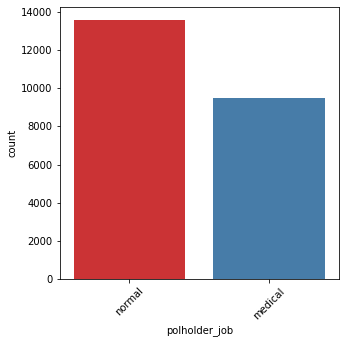

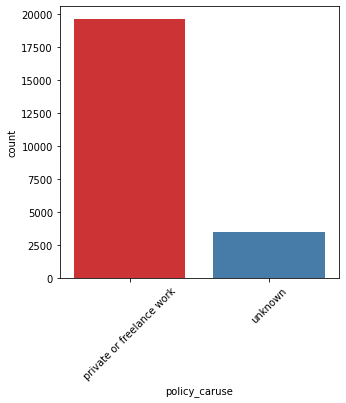

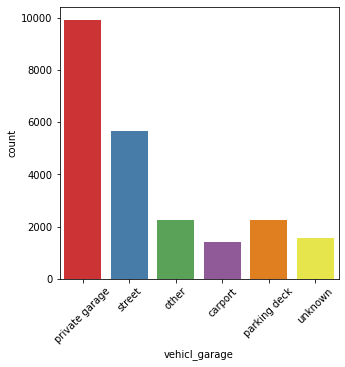

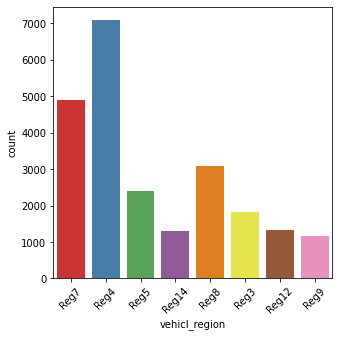

In [58]:
# graphical check
# Univariate analysis with barplots
for col in cat_fe:
    plt.figure(figsize=(5,5))
    sns.countplot(x=cat_fe[col], data=cat_fe, palette="Set1")
    plt.xticks(rotation=45)
    plt.show()

# Categorical Embedding

In [59]:
le = LabelEncoder()

In [60]:
cat_fe.columns[0]

'polholder_BMCevol'

In [61]:
le.fit(cat_fe.iloc[:,0])
cat_fe_BMCevol_enc = le.transform(cat_fe.iloc[:,0])
cat_fe_BMCevol_enc = np.array(cat_fe_BMCevol_enc)

In [62]:
embedding_size = cat_fe.shape[0]
out_dim=len(cat_fe.iloc[:,0].unique())

In [63]:
model = Sequential()
embedding_layer = Embedding(input_dim=embedding_size,output_dim=out_dim,input_length=1)
model.add(embedding_layer)
model.compile(loss='mse', optimizer='adam')
input_data = cat_fe_BMCevol_enc
pred = model.predict(input_data)
BMCevol_embeddings_df = pd.DataFrame(pred[:,0], columns = ['BMCevol_embeddings_1', 'BMCevol_embeddings_2'])

2022-08-25 13:26:13.118802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 13:26:13.120044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 13:26:13.120851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 13:26:13.121748: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [64]:
cat_fe.columns[1]

'polholder_diffdriver'

In [65]:
le.fit(cat_fe.iloc[:,1])
cat_fe_diffdriver_enc = le.transform(cat_fe.iloc[:,1])
cat_fe_diffdriver_enc = np.array(cat_fe_diffdriver_enc)

In [66]:
embedding_size = cat_fe.shape[0]
out_dim=len(cat_fe.iloc[:,1].unique())
model = Sequential()
embedding_layer = Embedding(input_dim=embedding_size,output_dim=out_dim,input_length=1)
model.add(embedding_layer)
model.compile(loss='mse', optimizer='adam')
input_data = cat_fe_BMCevol_enc
pred = model.predict(input_data)
diffdriver_embeddings_df = pd.DataFrame(pred[:,0], columns = ['diffdriver_1', 'diffdriver_2','diffdriver_3','diffdriver_4'])

In [67]:
cat_fe.columns[2]

'polholder_gender'

In [68]:
le.fit(cat_fe.iloc[:,2])
cat_fe_gender_enc = le.transform(cat_fe.iloc[:,2])
cat_fe_gender_enc = np.array(cat_fe_gender_enc)


In [69]:
embedding_size = cat_fe.shape[0]
out_dim=len(cat_fe.iloc[:,2].unique())
model = Sequential()
embedding_layer = Embedding(input_dim=embedding_size,output_dim=out_dim,input_length=1)
model.add(embedding_layer)
model.compile(loss='mse', optimizer='adam')
input_data = cat_fe_gender_enc
pred = model.predict(input_data)
gender_embeddings_df = pd.DataFrame(pred[:,0], columns = ['gender_1', 'gender_2'])

In [70]:
cat_fe.columns[3]

'polholder_job'

In [71]:
le.fit(cat_fe.iloc[:,3])
cat_fe_job_enc = le.transform(cat_fe.iloc[:,3])
cat_fe_job_enc = np.array(cat_fe_job_enc)

In [72]:
embedding_size = cat_fe.shape[0]
out_dim=len(cat_fe.iloc[:,3].unique())
model = Sequential()
embedding_layer = Embedding(input_dim=embedding_size,output_dim=out_dim,input_length=1)
model.add(embedding_layer)
model.compile(loss='mse', optimizer='adam')
input_data = cat_fe_job_enc
pred = model.predict(input_data)
job_embeddings_df = pd.DataFrame(pred[:,0], columns = ['job_1', 'job_2'])

In [73]:
cat_fe.columns[4]

'policy_caruse'

In [74]:
le.fit(cat_fe.iloc[:,4])
cat_fe_caruse_enc = le.transform(cat_fe.iloc[:,4])
cat_fe_caruse_enc = np.array(cat_fe_caruse_enc)

In [75]:
embedding_size = cat_fe.shape[0]
out_dim=len(cat_fe.iloc[:,4].unique())
model = Sequential()
embedding_layer = Embedding(input_dim=embedding_size,output_dim=out_dim,input_length=1)
model.add(embedding_layer)
model.compile(loss='mse', optimizer='adam')
input_data = cat_fe_caruse_enc
pred = model.predict(input_data)
caruse_embeddings_df = pd.DataFrame(pred[:,0], columns = ['caruse_1', 'caruse_2'])

In [76]:
cat_fe.columns[5]

'vehicl_garage'

In [77]:
le.fit(cat_fe.iloc[:,5])
cat_fe_garage_enc = le.transform(cat_fe.iloc[:,5])
cat_fe_garage_enc = np.array(cat_fe_garage_enc)

In [78]:
embedding_size = cat_fe.shape[0]
out_dim=len(cat_fe.iloc[:,5].unique())
model = Sequential()
embedding_layer = Embedding(input_dim=embedding_size,output_dim=out_dim,input_length=1)
model.add(embedding_layer)
model.compile(loss='mse', optimizer='adam')
input_data = cat_fe_garage_enc
pred = model.predict(input_data)
garage_embeddings_df = pd.DataFrame(pred[:,0], columns = ['garage_1', 'garage_2','garage_3','garage_4','garage_5','garage_6'])

In [79]:
cat_fe.columns[6]

'vehicl_region'

In [80]:
le.fit(cat_fe.iloc[:,6])
cat_fe_region_enc = le.transform(cat_fe.iloc[:,6])
cat_fe_region_enc = np.array(cat_fe_region_enc)

In [81]:
embedding_size = cat_fe.shape[0]
out_dim=len(cat_fe.iloc[:,6].unique())
model = Sequential()
embedding_layer = Embedding(input_dim=embedding_size,output_dim=out_dim,input_length=1)
model.add(embedding_layer)
model.compile(loss='mse', optimizer='adam')
input_data = cat_fe_region_enc
pred = model.predict(input_data)
region_embeddings_df = pd.DataFrame(pred[:,0], columns = ['region_1', 'region_2','region_3','region_4','region_5','region_6',
                                                         'region_7','region_8'])

In [82]:
# Grasp all
X_all = pd.concat([BMCevol_embeddings_df,diffdriver_embeddings_df,gender_embeddings_df,job_embeddings_df,
                   caruse_embeddings_df,garage_embeddings_df,region_embeddings_df,num_o,pca_df], axis=1)

### Zero Variance Predictors

In [83]:
# Find features with variance equal zero 
to_drop = [col for col in X_all.columns if np.var(X_all[col]) == 0]
to_drop

[]

In [84]:
# Drop features 
X_all_v = X_all.drop(X_all[to_drop], axis=1)

### Correlated Predictors

In [85]:
# Correlation 
corr_matrix = X_all_v.corr()

In [86]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.80)]
to_drop

['BMCevol_embeddings_2',
 'diffdriver_1',
 'diffdriver_2',
 'diffdriver_3',
 'diffdriver_4',
 'gender_2',
 'job_2',
 'caruse_2',
 'region_8',
 'prem_last',
 'prem_market',
 'prem_pure',
 'pca0',
 'pca2']

In [87]:
# Drop features 
X_all_c = X_all_v.drop(X_all_v[to_drop], axis=1)

In [88]:
X_all_c.shape

(23060, 32)

### Split data set

In [89]:
# Break off validation and test set from training data
X_train, X_test, y_train, y_test = train_test_split(X_all_c, y, train_size=0.9, test_size=0.1,stratify=y,
                                                                random_state=seed_value)



In [90]:
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [91]:
# Scaling datasets
X_train_sc = MinMaxScaler().fit_transform(X_train)
X_test_sc = MinMaxScaler().fit_transform(X_test)

# Tuning

In [92]:
# cross validation
skf = StratifiedKFold(n_splits=5, random_state=seed_value, shuffle=True)

In [93]:
# define models and parameters
NN = MLPClassifier(random_state=seed_value,activation='logistic', max_iter=100,learning_rate='invscaling')
# define the grid search parameters
neurons = [1, 5, 10, 15]
# define grid search
grid = dict(hidden_layer_sizes=neurons)
# Tuning and fit the model 
NN_model = GridSearchCV(NN, grid, n_jobs=-1, cv=skf, scoring='roc_auc',error_score=0).fit(X_train_sc, y_train)

In [94]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [95]:
display(NN_model)

Best parameters are: {'hidden_layer_sizes': 15}


0.612 + or -0.009 for the {'hidden_layer_sizes': 1}
0.616 + or -0.011 for the {'hidden_layer_sizes': 5}
0.617 + or -0.01 for the {'hidden_layer_sizes': 10}
0.617 + or -0.011 for the {'hidden_layer_sizes': 15}


In [96]:
# create model
X_train_oversampled, y_train_oversampled = RandomOverSampler(random_state=seed_value,sampling_strategy='minority').fit_resample(X_train_sc, y_train)
NN_ROS = MLPClassifier(random_state=seed_value,activation='logistic', max_iter=100,learning_rate='invscaling')
# define the grid search parameters
neurons = [1, 5, 10, 15]
# define grid search
grid = dict(hidden_layer_sizes=neurons)
# Tuning and fit the model 
NN_model_ROS = GridSearchCV(NN_ROS, grid, n_jobs=-1, cv=skf, scoring='roc_auc',error_score=0).fit(X_train_oversampled, y_train_oversampled)

In [97]:
display(NN_model_ROS)

Best parameters are: {'hidden_layer_sizes': 15}


0.621 + or -0.006 for the {'hidden_layer_sizes': 1}
0.63 + or -0.005 for the {'hidden_layer_sizes': 5}
0.631 + or -0.004 for the {'hidden_layer_sizes': 10}
0.632 + or -0.004 for the {'hidden_layer_sizes': 15}


In [98]:
# create model
X_train_undersampled, y_train_undersampled = RandomUnderSampler(random_state=seed_value,sampling_strategy='majority').fit_resample(X_train_sc, y_train)
NN_RUS = MLPClassifier(random_state=seed_value,activation='logistic', max_iter=100,learning_rate='invscaling')
# define the grid search parameters
neurons = [1, 5, 10, 15]
# define grid search
grid = dict(hidden_layer_sizes=neurons)
# Tuning and fit the model 
NN_model_RUS = GridSearchCV(NN_RUS, grid, n_jobs=-1, cv=skf, scoring='roc_auc',error_score=0).fit(X_train_undersampled, y_train_undersampled)

In [99]:
display(NN_model_RUS)

Best parameters are: {'hidden_layer_sizes': 15}


0.47 + or -0.006 for the {'hidden_layer_sizes': 1}
0.614 + or -0.006 for the {'hidden_layer_sizes': 5}
0.615 + or -0.006 for the {'hidden_layer_sizes': 10}
0.616 + or -0.006 for the {'hidden_layer_sizes': 15}


In [100]:
# create model
X_train_resampled, y_train_resampled = SMOTE(random_state=seed_value).fit_resample(X_train_sc, y_train)
NN_SMOTE = MLPClassifier(random_state=seed_value,activation='logistic', max_iter=100,learning_rate='invscaling')
# define the grid search parameters
neurons = [1, 5, 10, 15]
# define grid search
grid = dict(hidden_layer_sizes=neurons)
# Tuning and fit the model 
NN_model_SMOTE = GridSearchCV(NN_SMOTE, grid, n_jobs=-1, cv=skf, scoring='roc_auc',error_score=0).fit(X_train_resampled, y_train_resampled)

In [101]:
display(NN_model_SMOTE)

Best parameters are: {'hidden_layer_sizes': 15}


0.633 + or -0.005 for the {'hidden_layer_sizes': 1}
0.639 + or -0.003 for the {'hidden_layer_sizes': 5}
0.638 + or -0.003 for the {'hidden_layer_sizes': 10}
0.639 + or -0.004 for the {'hidden_layer_sizes': 15}


# Modelling

In [102]:
# cross validation
skf = StratifiedKFold(n_splits=5, random_state=seed_value, shuffle=True)
# create pipeline
param_grid = {}
NN_ = MLPClassifier(random_state=seed_value, hidden_layer_sizes=(15,),activation='logistic', max_iter=100,learning_rate='invscaling')
ROS = make_pipeline(RandomOverSampler(random_state=seed_value,sampling_strategy='minority'), MLPClassifier(random_state=seed_value,hidden_layer_sizes=(15,),activation='logistic', max_iter=100,learning_rate='invscaling'))
RUS = make_pipeline(RandomUnderSampler(random_state=seed_value,sampling_strategy='majority'), MLPClassifier(random_state=seed_value,hidden_layer_sizes=(15,),activation='logistic', max_iter=100,learning_rate='invscaling'))
SM = make_pipeline(SMOTE(random_state=seed_value), MLPClassifier(random_state=seed_value, hidden_layer_sizes=(15,),activation='logistic', max_iter=100,learning_rate='invscaling'))
# Define the model
NN_model_ = GridSearchCV(NN_,param_grid,cv=skf).fit(X_train_sc, y_train)
NN_model_ROS_ = GridSearchCV(ROS,param_grid,cv=skf).fit(X_train_sc, y_train)
NN_model_RUS_ = GridSearchCV(RUS,param_grid,cv=skf).fit(X_train_sc, y_train)
NN_model_SMOTE_ = GridSearchCV(SM,param_grid,cv=skf).fit(X_train_sc, y_train)                           

# Evaluation

In [103]:
# prediction
predictions_tr = NN_model_.predict_proba(X_train_sc)[:, 1]
predictions_tr_ = pd.DataFrame(predictions_tr, columns=['y_train_pred'])
predictions_tr_.to_csv('predictions_tr_nn.csv', index=False)
predictions_te = NN_model_.predict_proba(X_test_sc)[:, 1]
predictions_te_ = pd.DataFrame(predictions_te, columns=['y_test_pred'])
predictions_te_.to_csv('predictions_te_nn.csv', index=False)
predictions_tr_ros = NN_model_ROS_.predict_proba(X_train_sc)[:, 1]
predictions_tr_ros_ = pd.DataFrame(predictions_tr_ros, columns=['y_train_pred'])
predictions_tr_ros_.to_csv('predictions_tr_ros_nn.csv', index=False)
predictions_te_ros = NN_model_ROS_.predict_proba(X_test_sc)[:, 1]
predictions_te_ros_ = pd.DataFrame(predictions_te_ros, columns=['y_test_pred'])
predictions_te_ros_.to_csv('predictions_te_ros_nn.csv', index=False)
predictions_tr_rus = NN_model_RUS_.predict_proba(X_train_sc)[:, 1] 
predictions_tr_rus_ = pd.DataFrame(predictions_tr_rus, columns=['y_train_pred'])
predictions_tr_rus_.to_csv('predictions_tr_rus_nn.csv', index=False)
predictions_te_rus = NN_model_RUS_.predict_proba(X_test_sc)[:, 1]
predictions_te_rus_ = pd.DataFrame(predictions_te_rus, columns=['y_test_pred'])
predictions_te_rus_.to_csv('predictions_te_rus_nn.csv', index=False)
predictions_tr_smote = NN_model_SMOTE_.predict_proba(X_train_sc)[:, 1]
predictions_tr_smote_ = pd.DataFrame(predictions_tr_smote, columns=['y_train_pred'])
predictions_tr_smote_.to_csv('predictions_tr_smote_nn.csv', index=False)
predictions_te_smote = NN_model_SMOTE_.predict_proba(X_test_sc)[:, 1]
predictions_te_smote_ = pd.DataFrame(predictions_te_smote, columns=['y_test_pred'])
predictions_te_smote_.to_csv('predictions_te_smote_nn.csv', index=False)


In [104]:
# evaluation
auc_train = roc_auc_score(y_train, predictions_tr)
auc_test = roc_auc_score(y_test, predictions_te)
auc_train_ros = roc_auc_score(y_train, predictions_tr_ros)
auc_test_ros = roc_auc_score(y_test, predictions_te_ros)
auc_train_rus = roc_auc_score(y_train, predictions_tr_rus)
auc_test_rus = roc_auc_score(y_test, predictions_te_rus)
auc_train_smote = roc_auc_score(y_train, predictions_tr_smote)
auc_test_smote = roc_auc_score(y_test, predictions_te_smote)



In [105]:
# metrics table
d1 = {'evaluation': ['AUC','AUC','AUC','AUC'],
     'model': ['NN','NN_ROS','NN_RUS','NN_SMOTE'],
    'train': [auc_train,auc_train_ros,auc_train_rus,auc_train_smote],
    'test': [auc_test,auc_test_ros,auc_test_rus,auc_test_smote]
        }
df1 = pd.DataFrame(data=d1, columns=['model','evaluation','train','test'])
print('AUC NN evaluation on lapse prediction')
df1

AUC NN evaluation on lapse prediction


model evaluation     train      test
0        NN        AUC  0.627738  0.615909
1    NN_ROS        AUC  0.638706  0.628374
2    NN_RUS        AUC  0.622663  0.611564
3  NN_SMOTE        AUC  0.630379  0.621364

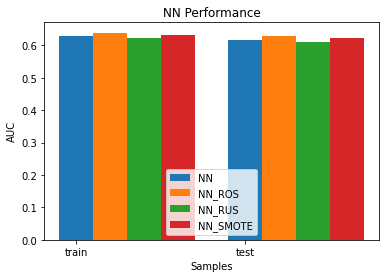

In [106]:
# plot results
X = ['train','test']
NN = [0.627738, 0.615909]
NN_ROS = [0.638706,0.628374]
NN_RUS = [0.622663,0.611564]
NN_SMOTE = [0.630379,0.621364]

X_axis = np.arange(len(X))
  
plt.bar(X_axis + 0.0, NN, 0.2, label = 'NN')
plt.bar(X_axis + 0.2, NN_ROS, 0.2, label = 'NN_ROS')
plt.bar(X_axis + 0.4, NN_RUS, 0.2, label = 'NN_RUS')
plt.bar(X_axis + 0.6, NN_SMOTE, 0.2, label = 'NN_SMOTE')

plt.xticks(X_axis, X)
plt.xlabel("Samples")
plt.ylabel("AUC")
plt.title("NN Performance")
plt.legend()
plt.show()

In [107]:
def plot_roc_auc(y_test, y_score, classes):
    plt.figure()
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,color='red', lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1],color='navy', lw=2, linestyle='--' )
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Receiver Operating Characteristic)')
    plt.legend(loc="lower right")
    plt.show()

ROC NN on train


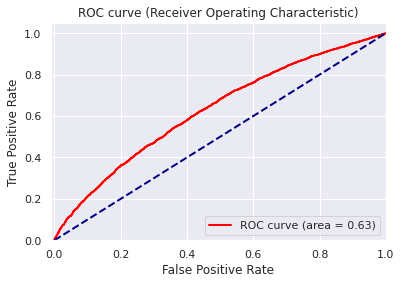

ROC NN on test


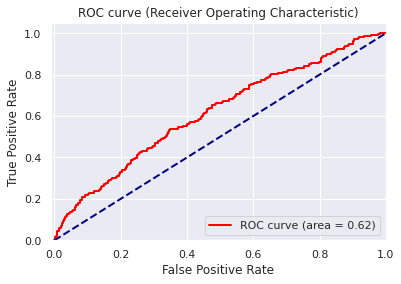

ROC NN on ROS train


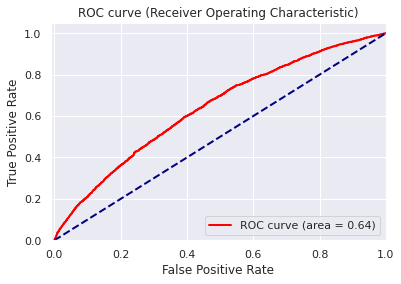

ROC NN on ROS test


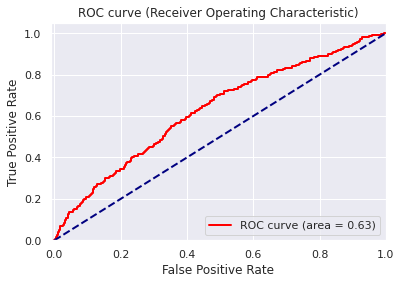

ROC NN on RUS train


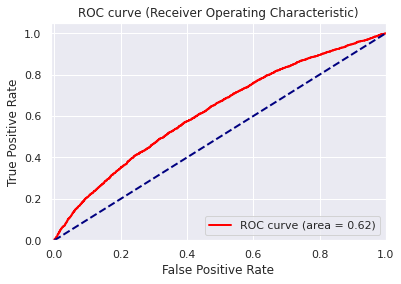

ROC NN on RUS test


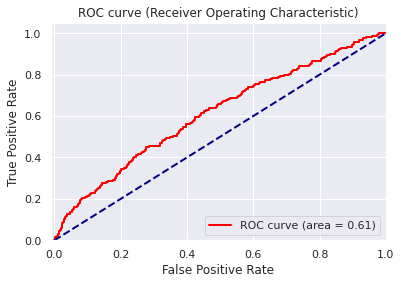

ROC NN on SMOTE train


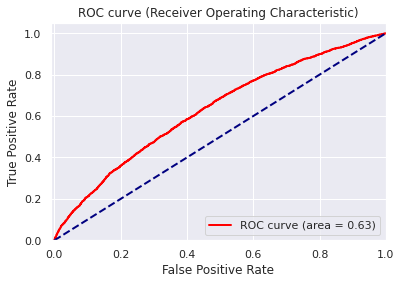

ROC NN on SMOTE test


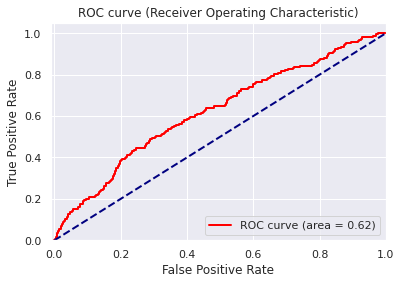

In [108]:
sns.set()
print('ROC NN on train')
plot_roc_auc(y_train, predictions_tr, 2)
print('ROC NN on test')
plot_roc_auc(y_test, predictions_te, 2)
print('ROC NN on ROS train')
plot_roc_auc(y_train, predictions_tr_ros, 2)
print('ROC NN on ROS test')
plot_roc_auc(y_test, predictions_te_ros, 2)
print('ROC NN on RUS train')
plot_roc_auc(y_train, predictions_tr_rus, 2)
print('ROC NN on RUS test')
plot_roc_auc(y_test, predictions_te_rus, 2)
print('ROC NN on SMOTE train')
plot_roc_auc(y_train, predictions_tr_smote, 2)
print('ROC NN on SMOTE test')
plot_roc_auc(y_test, predictions_te_smote, 2)
plt.show()



# Permutation Feature Importance

In [109]:
# Permutation importance train
print('NN Features Permutation Importance on train')
perm = PermutationImportance(NN_model_ROS_, random_state=seed_value).fit(X_train_sc, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

NN Features Permutation Importance on train


In [110]:
# Permutation importance test
print('NN Features Permutation Importance on test')
perm = PermutationImportance(NN_model_ROS, random_state=seed_value).fit(X_test_sc, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

NN Features Permutation Importance on test


# Partial Dependence Plots

Partial dependence of lapse on some features with NN model


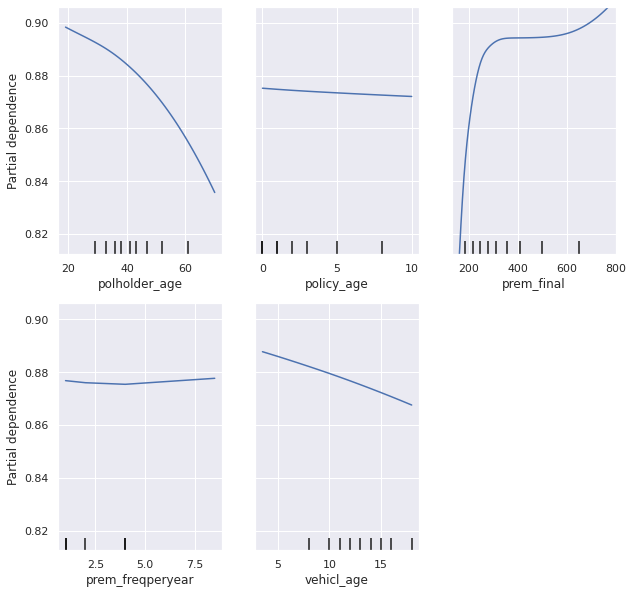

In [111]:
sns.set(rc={'figure.figsize': (10, 10)})
PartialDependenceDisplay.from_estimator(NN_model_ROS_,X_all_c,['polholder_age', 'policy_age', 'prem_final','prem_freqperyear','vehicl_age'], 
                                        kind='average')
print("Partial dependence of lapse on some features with NN model")
plt.show()

# Individual Conditional Expectation (ICE) Plot 

Individual Conditional Expectation of lapse on some features with NN model


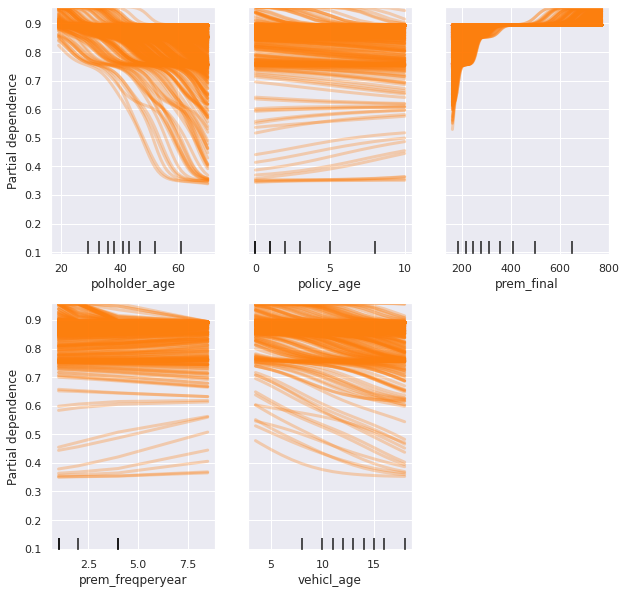

In [112]:
sns.set(rc ={'figure.figsize': (10, 10)})
PartialDependenceDisplay.from_estimator(NN_model_ROS_,X_all_c,['polholder_age', 'policy_age', 'prem_final','prem_freqperyear','vehicl_age'], 
                                kind='individual', ice_lines_kw={"color": "tab:orange", "alpha": 0.3, "linewidth": 3})
print("Individual Conditional Expectation of lapse on some features with NN model")
plt.show()

# SHAP

In [113]:
explainer = shap.KernelExplainer(NN_model_ROS_.predict_proba,X_train_oversampled[1000:1500,:])

In [114]:
shap.initjs()
# Local SHAP on train
print("NN LOCAL SHAP on train Values")
i=1250
shap_values = explainer.shap_values(X_train_oversampled[i,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_train_oversampled[i,:], feature_names=X_train.columns)

NN LOCAL SHAP on train Values


NN SHAP BARPLOT on train Values


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multi

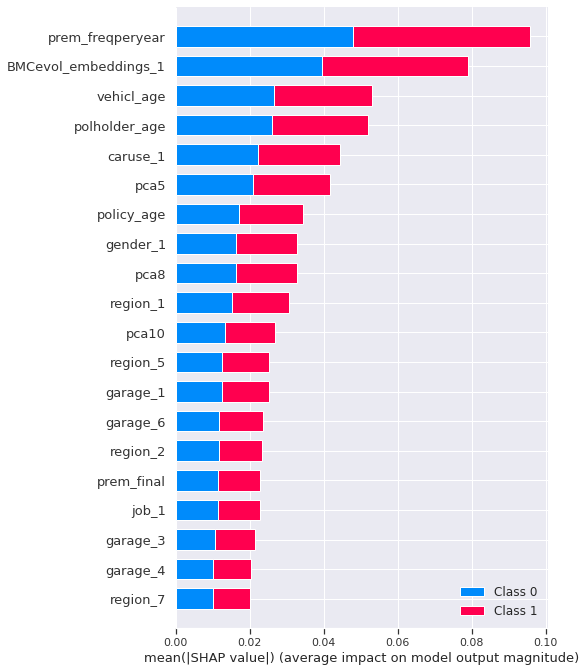

In [115]:
# Global SHAP on train
print("NN SHAP BARPLOT on train Values")
shap_values = explainer.shap_values(X_train_oversampled[1000:1500,:])
shap.summary_plot(shap_values, features=X_train_oversampled, feature_names=X_train.columns,plot_type='bar')

In [116]:
shap.initjs()
# Local SHAP on test
print("NN LOCAL SHAP on test Values")
i=1250
shap_values = explainer.shap_values(X_test_sc[i,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_sc[i,:], feature_names=X_test.columns)

NN LOCAL SHAP on test Values


NN SHAP BARPLOT on test Values


  0%|          | 0/500 [00:00<?, ?it/s]

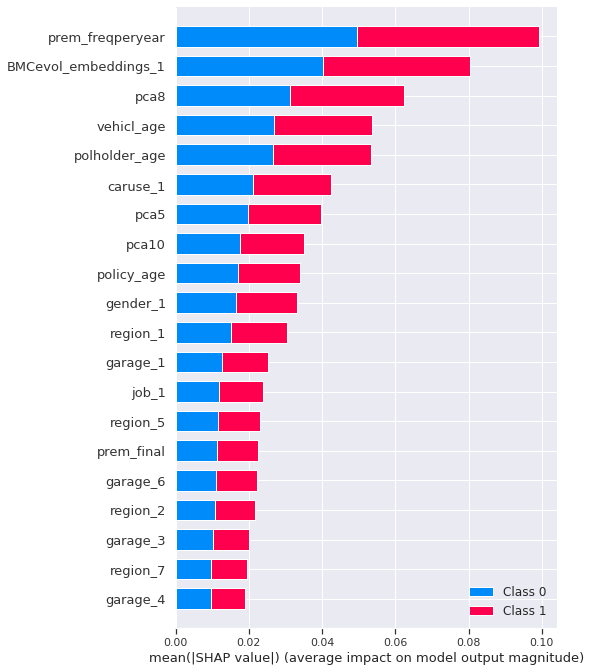

In [117]:
# Global SHAP on test
print("NN SHAP BARPLOT on test Values")
shap_values = explainer.shap_values(X_test_sc[1000:1500,:])
shap.summary_plot(shap_values, features=X_test_sc, feature_names=X_test.columns,plot_type='bar')

# LIME

In [118]:
# Local Explainability with LIME
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_sc, mode="classification",
                                              class_names=['0','1'], verbose=False,
                                              feature_names=X_all_c.columns)

explainer

In [119]:
i = 1250

print('NN LIME on Train Values')
exp = explainer.explain_instance(X_train_sc[i], NN_model_ROS_.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)


NN LIME on Train Values


In [120]:
i = 1250

print('NN LIME on Test Values')
exp = explainer.explain_instance(X_test_sc[i], NN_model_ROS_.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)


NN LIME on Test Values
